# Import Modules

In [94]:
import json

import pandas as pd
import numpy as np
import torch

import utils

# Set Vegetable

In [114]:
vegetable = utils.VEGETABLES[9]
training_size = 4000

json_open = open('./free_params.json', 'r')
params = json.load(json_open)
param = params[vegetable]

print(f"vegetable: {vegetable}")
print(f"free params: {param}")
print(f"training size: {training_size}")

vegetable: トマト
free params: {'T': 10, 'batch_size': 16, 'num_epochs': 150, 'learning_rate': 0.001, 'weight_decay': 0.001, 'eps': 1e-08, 'hidden_size': 500, 'dropout_ratio': 0.5, 'is_attention': 1, 'num_ensamble': 5, 'seed': 1}
training size: 4000


# Load Data

In [115]:
train_test = pd.read_csv("./data/mapped_train_test.csv")
train_test["date"] = pd.to_datetime(train_test["date"], format="%Y-%m-%d")
weather = pd.read_csv("./data/sorted_mapped_adjusted_weather.csv")
train_test = pd.concat([train_test, weather], axis=1)

train_test["year"] = train_test.date.dt.year
years = pd.get_dummies(train_test["year"])
train_test = train_test.drop(columns="year")
train_test = pd.concat([train_test, years], axis=1)

train_test["month"] = train_test.date.dt.month
months = pd.get_dummies(train_test["month"])
train_test = train_test.drop(columns="month")
train_test = pd.concat([train_test, months], axis=1)

areas = pd.get_dummies(train_test["area"])
train_test = train_test.drop(columns="area")
train_test = pd.concat([train_test, areas], axis=1)

train = train_test[:pd.read_csv("./data/train.csv").shape[0]]

target_values = utils.get_target_values(train, vegetable)
changed_col = [1, 0] + [i for i in np.arange(2, target_values.shape[1])]
target_values = target_values[:, changed_col]
train_loader, test_y, train, test, ss = utils.preprocess_data(target_values, train_size=training_size,
                                                              T=param["T"], batch_size=param["batch_size"])

# Set Free Params

In [116]:
future = test.shape[0]

is_attention = param["is_attention"]
num_epochs = param["num_epochs"]
learning_rate = param["learning_rate"]
weight_decay = param["weight_decay"]
eps = param["eps"]
hidden_size = param["hidden_size"]
dropout_ratio = param["dropout_ratio"]
SEED = param["seed"]

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Training

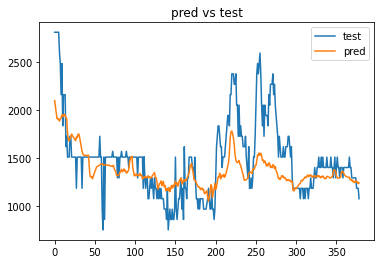

In [117]:
pred_y, _ = utils.pipeline_rnn(train_loader, train, test, test_y, future=future, num_epochs=num_epochs, lr=learning_rate,
                               weight_decay=weight_decay, eps=eps, hidden_size=hidden_size, dropout_ratio=dropout_ratio, is_attention=is_attention)

pred_y = pred_y.cpu().detach().numpy()
pred = np.concatenate([pred_y.reshape(-1, 1), test[:, 1:]], axis=1)

utils.plot_prediction(pred, test, ss)